<a href="https://colab.research.google.com/github/JCaballerot/Consultoria_ASEI/blob/main/Model_development/Miraflores/modelDevelopment_zona1_M_rev.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5>Forecasting Miraflores Zona 1
</font></h1>

---

# Librerias



Cargamos las librerías que utilizaremos en el proyecto

In [ ]:
import pandas as pd

import warnings                                  
warnings.filterwarnings('ignore')

import numpy as np                               
import pandas as pd                              
import matplotlib.pyplot as plt                  
import seaborn as sns                            

from sklearn.metrics import *

In [ ]:
def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend",  color='red')

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.xticks(rotation=90)

# Data

Importamos la información desde un archivo csv cargado en el file temporal y nos quedamos con los datos de la zona 2

In [ ]:
target = 'Venta_zona_1'

pddf = pd.read_csv('datos_miraflores.csv',delimiter=',', index_col=['codmes'], parse_dates=['codmes']).fillna(0)
pddf = pddf[[target]]

pddf[target+'_lag2'] = pddf[target].shift(2)
pddf[target+'_lag3'] = pddf[target].shift(3)


In [ ]:
macro = pd.read_csv('macros_corregido.csv', index_col=['codmes'], parse_dates=['codmes']).drop(columns=['imp_mater_const'])
variables_macro = macro.columns.tolist()
macro[variables_macro] = macro[variables_macro].shift(3)


In [ ]:
asei = pd.read_csv('variables_asei_new.csv', delimiter = ';', index_col=['codmes'], parse_dates=['codmes'])
variables_asei = asei.columns.tolist()
asei[variables_asei] = asei[variables_asei].shift(2)

In [ ]:

pddf2 = pd.merge(pddf, macro, on = 'codmes', how='left').copy()
pddf2 = pd.merge(pddf2, asei, on = 'codmes', how='left')

variables = variables_macro + variables_asei + [target+'_lag2', target+'_lag3']


In [ ]:
pddfRes = pddf2.copy()

pddfRes[[x + '_avg3' for x in variables]] = pddfRes[variables].rolling(3, min_periods = 3).mean()
pddfRes[[x + '_avg6' for x in variables]] = pddfRes[variables].rolling(6, min_periods = 6).mean()

pddfRes = pddfRes.iloc[8:]


In [ ]:
for x in variables:
  pddfRes[x + '_rat3to6'] = pddfRes[x + '_avg3']/pddfRes[x + '_avg6']
  

In [ ]:

variables_f = variables_macro +\
              variables_asei +\
              [target+'_lag2', target+'_lag3'] +\
              [x + '_avg3' for x in variables] +\
              [x + '_avg6' for x in variables] +\
              [x + '_rat3to6' for x in variables]


In [ ]:
pddfRes['intercept'] = 1

In [ ]:
test_size = 2

data = pddfRes.copy().dropna()
X_train = pddfRes[:-test_size].dropna()
X_test  = pddfRes[-test_size:].dropna()


In [ ]:
# Estandarización

X_train[[x + '_std' for x in variables_f]] = (X_train[variables_f] - X_train[variables_f].mean())/X_train[variables_f].std()
X_test[[x + '_std'  for x in variables_f]] = (X_test[variables_f]  - X_train[variables_f].mean())/X_train[variables_f].std()
data[[x + '_std'    for x in variables_f]] = (data[variables_f]    - X_train[variables_f].mean())/X_train[variables_f].std()



In [ ]:
X_train[['precio_oferta_zon1_rat3to6', 'exp_PBI_avg3', 'flg_feia_avg3']].mean()

precio_oferta_zon1_rat3to6    1.005935
exp_PBI_avg3                  0.045776
flg_feia_avg3                 0.340741
dtype: float64

In [ ]:
X_train[['precio_oferta_zon1_rat3to6', 'exp_PBI_avg3', 'flg_feia_avg3']].std()

precio_oferta_zon1_rat3to6    0.008043
exp_PBI_avg3                  0.016491
flg_feia_avg3                 0.194481
dtype: float64

# Forecasting

### Exploracion

Muestreamos la data en train y test bajo metodología OOT

In [ ]:
plotMovingAverage(data[target], 6)

In [ ]:
plotMovingAverage(data[target], 6, plot_intervals=True, scale=1.64, plot_anomalies=False)

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(X_train[target].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

Dado que el valor p es mayor que el nivel de significancia (0,05), diferenciemos las series y veamos cómo se ve el gráfico de autocorrelación.

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(X_train[target]); axes[0, 0].set_title('Original Series')
plot_acf(X_train[target], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(X_train[target].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(X_train[target].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(X_train[target].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(X_train[target].diff().diff().dropna(), ax=axes[2, 1])

plt.xticks(rotation=90)
plt.show()

Por los datos anteriores, podemos ver que la serie de tiempo alcanza la estacionariedad con dos órdenes de diferenciación.

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(X_train[target].diff().dropna(), ax=axes[1])

plt.xticks(rotation=90)
plt.show()

Podemos ver que el retraso 1 de PACF es bastante significativo ya que está muy por encima de la línea de significancia. Entonces, fijaremos el valor de p como 1.

### MA (q) 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(X_train[target].diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(X_train[target].diff().dropna(), ax=axes[1])
plt.xticks(rotation=90)
plt.show()


Podemos ver que un 1 retraso están muy por encima de la línea de significación. Entonces, fijaremos q como 1. Si hay alguna duda, iremos con el modelo más simple que explica suficientemente la Y

### Arima

Ahora, hemos determinado los valores de p, d y q. Disponemos de todo lo necesario para adaptarse al modelo ARIMA. Usaremos la implementación ARIMA() en el paquete statsmodels.
(p,d,q)

In [ ]:
# Plot
fig, axes = plt.subplots(2, 1, figsize=(10,5), dpi=100, sharex=True)

# Usual Differencing
axes[0].plot(X_train[target], label='Original Series')
axes[0].plot(X_train[target].diff(1), label='Usual Differencing')
axes[0].set_title('Usual Differencing')
axes[0].legend(loc='upper left', fontsize=10)


# Seasonal Differencing
axes[1].plot(X_train[target], label='Original Series')
axes[1].plot(X_train[target].diff(12), label='Seasonal Differencing', color='green')
axes[1].set_title('Seasonal Differencing')
plt.legend(loc='upper left', fontsize=10)
plt.suptitle('Ventas Zona 3', fontsize=16)
plt.xticks(rotation=90)
plt.show()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

features = [target + '_lag2_avg3']

# 2,1,1 ARIMA Model
model = ARIMA(endog = X_train[target], 
              exog = X_train[features],  
              order=(1,2,1))

model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:        D2.Venta_zona_1   No. Observations:                   43
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -143.792
Method:                       css-mle   S.D. of innovations              6.517
Date:                Thu, 21 Jul 2022   AIC                            297.585
Time:                        16:18:02   BIC                            306.391
Sample:                             2   HQIC                           300.832
                                                                              
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      1.0562      1.257      0.840      0.406      -1.408       3.520
Venta_zona_1_lag2_avg3    -0.0840      0.102     -0.824      0.415      -0.284       0.116
ar.L

In [ ]:

import pickle
pickle.dump(model_fit, open("./arima_mz1.ml", 'wb'))


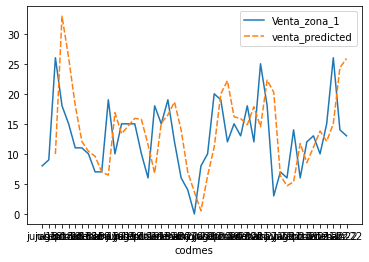

In [ ]:

fc, se, conf  = model_fit.forecast(test_size, exog = X_test[features], alpha=0.05)
model_res = model_fit.predict(start = X_train.index[2], 
                                end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted'] = model_res
data_res.iloc[-test_size:]['venta_predicted'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted']])


In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Los errores residuales parecen correctos con una media cercana a cero y una varianza uniforme. Grafiquemos los valores reales contra los valores ajustados usando plot_predict().

In [ ]:
pd.set_option('display.max_rows', 500)

In [ ]:
data_res[['venta_predicted',target]]

In [ ]:
data_res[['venta_predicted',target]].to_csv('results_JM_zona2.csv', index=0)

In [ ]:

data = data_res.copy().dropna()
X_train = data_res[:-test_size].dropna()
X_test  = data_res[-test_size:].dropna()



In [ ]:
X_test[['venta_predicted', target]]

In [ ]:
X_test[['venta_predicted', target]].corr()**2

,venta_predicted,Venta_zona_2
venta_predicted,1.0,1.0
Venta_zona_2,1.0,1.0


# Inputs Regresión

In [ ]:
correlations = pd.DataFrame()

for col in variables_f:
  data_temp = X_train[[target, col]]
  correlation = data_temp[col].corr(data_temp[target])
  temp = pd.DataFrame({'target': [target],'variable': [col], 'correlacion' : [correlation]})
  correlations = correlations.append(temp)

correlations['correlacion_abs'] = correlations.correlacion.apply(lambda x: abs(x))
correlations['r2'] = correlations.correlacion.apply(lambda x: x**2)

correlations.sort_values(by = 'correlacion_abs', ascending = False, inplace = True)


In [ ]:
correlations.head(50)

# Regresion

In [ ]:
pd.set_option('display.max_rows', None)

macro = pd.read_csv('macros_corregido.csv', index_col=['codmes'], parse_dates=['codmes']).drop(columns=['imp_mater_const'])

macro[['exp_PBI', 
       'ind_prec_cons_lima_met_alim_ener', 
       'ind_prec_inf_suby_bienes', 
       'ind_prec_inm',
       'prod_ener_lima',
       'var_porc_demanda_interna']]

       

In [ ]:
import statsmodels.api as sm

features = ['intercept',  'precio_oferta_zon1_rat3to6_std', 'exp_PBI_avg3_std',
            'flg_feia_avg3_std']

# Fit and summarize OLS model
mod = sm.OLS(X_train[target], 
             X_train[features])

res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:           Venta_zona_1   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.253
Method:                 Least Squares   F-statistic:                     5.751
Date:                Thu, 21 Jul 2022   Prob (F-statistic):            0.00234
Time:                        17:12:43   Log-Likelihood:                -129.54
No. Observations:                  43   AIC:                             267.1
Df Residuals:                      39   BIC:                             274.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept   

In [ ]:
1.8231/(2.2126 + 1.2573 + 1.8231)

0.344436047610051

In [ ]:
2.2126 + 1.2573 + 1.8231

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

sn.heatmap(X_train[features].corr(), annot=True)
plt.show()

In [ ]:

data_res['macro_pred'] = 12.7242 -\
                         2.2126*data_res.precio_oferta_zon1_rat3to6_std +\
                         1.2573*data_res.exp_PBI_avg3_std +\
                         1.8231*data_res.flg_feia_avg3_std

data = data_res.copy().dropna()
X_train = data[:-test_size].dropna()
X_test  = data[-test_size:].dropna()


In [ ]:
#target + '_lag3_avg3'
ensemble = ['venta_predicted', 'macro_pred']

# 2,1,1 ARIMA Model
model_ff = ARIMA(endog = X_train[target], 
                 exog = X_train[ensemble],  
                 order=(1,2,1))

model_fit_ff = model_ff.fit()
print(model_fit_ff.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:        D2.Venta_zona_1   No. Observations:                   41
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -129.504
Method:                       css-mle   S.D. of innovations              5.389
Date:                Thu, 21 Jul 2022   AIC                            271.008
Time:                        17:13:01   BIC                            281.289
Sample:                             2   HQIC                           274.752
                                                                              
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.5445      1.026      2.479      0.018       0.533       4.556
venta_predicted          -0.2723      0.094     -2.891      0.006      -0.457      -0.088
macro_pr

In [ ]:

import pickle
pickle.dump(model_fit_ff, open("./var_mz1.ml", 'wb'))


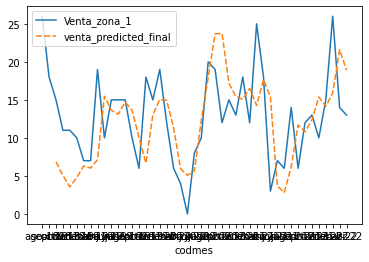

In [ ]:

fc, se, conf  = model_fit_ff.forecast(test_size, 
                                      exog = X_test[['venta_predicted', 'macro_pred']], alpha=0.05)

model_res = model_fit_ff.predict(start = X_train.index[2], 
                                 end = X_train.index[-1], dynamic=False, typ = 'levels')

data_res = data.copy()
data_res['venta_predicted_final'] = model_res
data_res.iloc[-test_size:]['venta_predicted_final'] = fc

sns.lineplot(data = data_res[[target, 'venta_predicted_final']])


In [ ]:
data_res[[target, 'venta_predicted', 'macro_pred', 'venta_predicted_final']]

In [ ]:
mod = sm.OLS(X_train[target], X_train[['venta_predicted', 'macro_pred', 'intercept']])
res = mod.fit()
print(res.summary())

In [ ]:

data_res['venta_predicted_final'] = 0.1938*data_res.venta_predicted + 0.9125*data_res.macro_pred - 6.1913


data = data_res.copy().dropna()
X_train = data[:-test_size].dropna()
X_test  = data[-test_size:].dropna()



In [ ]:
X_train[['venta_predicted_final', target]].corr()**2

,venta_predicted_final,Venta_zona_1
venta_predicted_final,1.000000,0.250031
Venta_zona_1,0.250031,1.000000


In [ ]:
data[['venta_predicted',
      'venta_predicted_final', target]].to_csv('results_zona1.csv', index=0)

In [ ]:
data[['venta_predicted',
      'venta_predicted_final', target]]

In [ ]:
X_test[features]

,Venta_zona_1_lag3_avg3
codmes,
abr-22,63.000000
may-22,55.333333


# Implementación

In [ ]:
data[[target + '_lag2_avg3', 'precio_oferta_zon1_rat3to6_std', 'exp_PBI_avg3_std', 'flg_feia_avg3_std']]

In [ ]:
input = pd.DataFrame({target + '_lag2_avg3' : [17, 17, 17, 17, 17, 17],
                      'precio_oferta_zon1_rat3to6_std' : [-2.706251]*6,
                      'exp_PBI_avg3_std' : [-1.138502	]*6,
                      'flg_feia_avg3_std' : [-0.038088]*6
                      },
                      index = ['may-22','jun-22', 'jul-22', 'ago-22', 'sept-22', 'oct-22'])         

                                          


In [ ]:
fc_pred, se, conf  = model_fit.forecast(6, exog = input[target + '_lag2_avg3'], alpha=0.05)
input['venta_predicted'] = fc_pred
fc_pred

array([23.9875348 , 25.15805161, 24.95722096, 24.66576802, 23.92353946,
       22.83181416])

In [ ]:

input['macro_pred'] = 12.7242 -\
                         2.2126*input.precio_oferta_zon1_rat3to6_std +\
                         1.2573*input.exp_PBI_avg3_std +\
                         1.8231*input.flg_feia_avg3_std
                         
#input['venta_predicted_final'] = 0.1938*input.venta_predicted + 0.9125*input.macro_pred - 6.1913


In [ ]:
fc_pred, se, conf  = model_fit_ff.forecast(6, exog = input[['venta_predicted', 'macro_pred']], alpha=0.05)
input['venta_predicted_final'] = fc_pred
input['venta_predicted_final']
fc_pred

array([ 21.83530432,  19.58206289,  12.55123676,   3.43662305,
        -8.57325453, -22.78818252])

In [ ]:
input['macro_pred']

may-22     17.211174
jun-22     17.211174
jul-22     17.211174
ago-22     17.211174
sept-22    17.211174
oct-22     17.211174
Name: macro_pred, dtype: float64